<h1 align="center">🚕</h1>
<h1 align="center">Predicting the Taxi Fare of New York City riders using Machine Learning</h1>

<hr/>
<div align="center">In this notebook, the goal is to predict the New York City Taxi Fare.</div>

## The big picture.

### 1. Problem

> How well can we predict the fare amount for a taxi ride in New York City, given the pickup and dropoff locations ?

### 2. Data

The data is downloaded from the Kaggle New York City Taxi Fare Prediction competition:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

There are two main datasets:
- **Train.csv**, the training set, which contains data from January 1, 2009 - June 30, 2015.
- **Test.csv**, the test set, which contains data from January 1, 2009 - June 30, 2015.

### 3. Evaluation

The evaluation metric for this competition is the **RMSE (Root Mean-Squared Error)** between the actual and predicted fare amount.

Since taxi driver' strategy is based on customer satisfaction and transparency, we want the estimated fare amount to result in an minimal RMSE.

For more on the evaluation on this project check:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### 4. Features

* `pickup_datetime` - timestamp value indicating when the taxi ride started.
* `pickup_longitude` - float for longitude coordinate of where the taxi ride started.
* `pickup_latitude` - float for latitude coordinate of where the taxi ride started.
* `dropoff_longitude` - float for longitude coordinate of where the taxi ride ended.
* `dropoff_latitude` - float for latitude coordinate of where the taxi ride ended.
* `passenger_count` - integer indicating the number of passengers in the taxi ride.
* `fare_amount` - float dollar amount of the cost of the taxi ride.

### 5. Frame the problem

It is clearly a typical **supervised learning task**, since we are given a target variable `fare_amount`.

It is also a typical **regression task**, since we aimed to predict a value, the amount of the cost of the taxi ride.

More specifically, it is a **multiple regression problem**, since the system will use multiple features to make a prediction, and a **univariate regression problem**, since we are only trying to predict a single value for each taxi ride.

Finally, there is no continuous flow of data coming into the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so **plain batch learning** should do just fine.

<hr/>

In [1]:
# Standard imports

# Regular EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,9.27)})
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Transformation libraries
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

## 1. Get the Data.

In [2]:
# Load the training set, we are sampling the data down to a manageable size which is good to get started
NB_ROWS = 20000 
taxi_train_set = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS)

In [3]:
# Load the test set
taxi_test_set = pd.read_csv("datasets/new-york-city-taxi/test.csv")

In [4]:
taxi_train_set.shape, taxi_test_set.shape

((20000, 8), (9914, 7))

In [5]:
#/?\ I could create here a function to fetch the data
#/!\ I also need to shuffle the data when I sample it down (see page 52 end + 53), avoid the sampling bias, make sure that the 20000 instances are representative? or test set?

# Further in the notebook, we have to make sure that the test set is representative of the whole taxi rides. (page 54)
# or like in page 56, we can process the strat_.. here in order to have a sample (20000) representative of the test set we are given ?

#### Copy of the original DataFrame for exploration
We keep a copy of the original DataFrame so when we manipulate the dataset, we've still got our original data.

In [6]:
taxi_original_set = taxi_train_set.copy()

## 2. EDA.

We will here try to find out more about the data.

In [7]:
taxi_train_set.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
taxi_train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                20000 non-null  object 
 1   fare_amount        20000 non-null  float64
 2   pickup_datetime    20000 non-null  object 
 3   pickup_longitude   20000 non-null  float64
 4   pickup_latitude    20000 non-null  float64
 5   dropoff_longitude  20000 non-null  float64
 6   dropoff_latitude   20000 non-null  float64
 7   passenger_count    20000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.2+ MB


In [9]:
taxi_train_set.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,11.303321,-72.478584,39.921043,-72.497221,39.913606,1.658000
std,9.541637,10.525376,6.678592,10.460530,6.139231,1.283674
min,-3.000000,-74.438233,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992150,40.734706,-73.991224,40.734537,1.000000
50%,8.500000,-73.981711,40.752680,-73.980216,40.753583,1.000000
75%,12.500000,-73.966802,40.767443,-73.963729,40.768135,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


In [10]:
taxi_train_set["fare_amount"].value_counts()

6.50     951
4.50     834
8.50     774
5.30     574
6.10     565
        ... 
37.53      1
41.04      1
59.10      1
22.54      1
28.54      1
Name: fare_amount, Length: 483, dtype: int64

In [11]:
# % of missing values
taxi_train_set.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [12]:
# Show the percentage of missing values for each column (We create a function because we will use it repeatedly)
def display_na(df): 
    """
    The function displays the percentage of missing values for each column of the dataframe.
    
    :param df: pandas dataframe whose missing values to be displayed
    """
    
    print("Percentage of missing variables for each feature:")
    print(df.isnull().sum(axis=0) * 100 / len(df))
    
display_na(taxi_train_set)

Percentage of missing variables for each feature:
key                  0.0
fare_amount          0.0
pickup_datetime      0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64


Each row represents one race. There are 7 attributes: `key`, `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude` and `passenger_count`.

All attributes are numerical except the `key` and the `pickup_datetime` fields. For `pickup_datetime`, its type is object, but we know that it must be a date attribute. `key` is the combination of `pickup_datetime` and an id.

There are 20,000 instances in the dataset. Notice that none of the attributes contain null values in our reduced dataset.

In [13]:
taxi_train_set['pickup_datetime'].min(), taxi_train_set['pickup_datetime'].max()

('2009-01-01 01:31:49 UTC', '2015-06-30 22:42:39 UTC')

This is a **6 years and a half** dataset that we need to explore and try to make different analysis on each of its features.

### Different transformations on our data

**Parsing dates:** As we are working with time series data, we want to enrich the time and date component as much as possible.

In [14]:
# We import the data again but we parse dates
taxi_train_set = pd.read_csv("datasets/new-york-city-taxi/train.csv", nrows=NB_ROWS,
                  low_memory=False,
                  parse_dates=["pickup_datetime"])
taxi_train_set.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [15]:
taxi_train_set.pickup_datetime.dtype

datetime64[ns, UTC]

In [16]:
taxi_train_set.pickup_datetime[:10]

0   2009-06-15 17:26:21+00:00
1   2010-01-05 16:52:16+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
5   2011-01-06 09:50:45+00:00
6   2012-11-20 20:35:00+00:00
7   2012-01-04 17:22:00+00:00
8   2012-12-03 13:10:00+00:00
9   2009-09-02 01:11:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

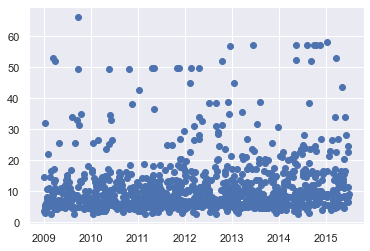

In [17]:
fig, ax = plt.subplots()
ax.scatter(taxi_train_set["pickup_datetime"][:1000], taxi_train_set["fare_amount"][:1000]);

In [18]:
# Sort DataFrame in date order
taxi_train_set.sort_values(by=["pickup_datetime"], inplace=True, ascending=True)
taxi_train_set.pickup_datetime.head(10)

12739   2009-01-01 01:31:49+00:00
17546   2009-01-01 02:05:37+00:00
8684    2009-01-01 02:51:52+00:00
11623   2009-01-01 15:19:00+00:00
10004   2009-01-01 16:52:00+00:00
7756    2009-01-01 17:07:00+00:00
13904   2009-01-01 19:57:19+00:00
16313   2009-01-01 22:40:03+00:00
2354    2009-01-02 02:32:41+00:00
7704    2009-01-02 06:35:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [19]:
# Add datetime parameters for pickup_datetime column
taxi_train_set["pickupYear"] = taxi_train_set.pickup_datetime.dt.year
taxi_train_set["pickupMonth"] = taxi_train_set.pickup_datetime.dt.month
taxi_train_set["pickupDay"] = taxi_train_set.pickup_datetime.dt.day
taxi_train_set["pickupDayOfWeek"] = taxi_train_set.pickup_datetime.dt.dayofweek
taxi_train_set["pickupDayOfYear"] = taxi_train_set.pickup_datetime.dt.dayofyear
taxi_train_set["pickupHour"] = taxi_train_set.pickup_datetime.dt.hour

In [20]:
taxi_train_set.head().T

,12739,17546,8684,11623,10004
key,2009-01-01 01:31:49.0000003,2009-01-01 02:05:37.0000004,2009-01-01 02:51:52.0000002,2009-01-01 15:19:00.000000146,2009-01-01 16:52:00.00000053
fare_amount,8.600000,11.000000,10.200000,5.300000,8.500000
pickup_datetime,2009-01-01 01:31:49+00:00,2009-01-01 02:05:37+00:00,2009-01-01 02:51:52+00:00,2009-01-01 15:19:00+00:00,2009-01-01 16:52:00+00:00
pickup_longitude,-73.994192,-73.978433,-73.956172,-73.949937,-73.967647
pickup_latitude,40.720077,40.744781,40.771965,40.784427,40.763077
dropoff_longitude,-73.993356,-74.004713,-73.991027,-73.948735,-73.977438
dropoff_latitude,40.742642,40.734328,40.751035,40.773738,40.787097
passenger_count,1,1,2,5,2
pickupYear,2009,2009,2009,2009,2009
pickupMonth,1,1,1,1,1


In [21]:
# We don't need the pickup_datetime attribute anymore
taxi_train_set.drop("pickup_datetime", axis=1, inplace=True)

### Visualizing the Data

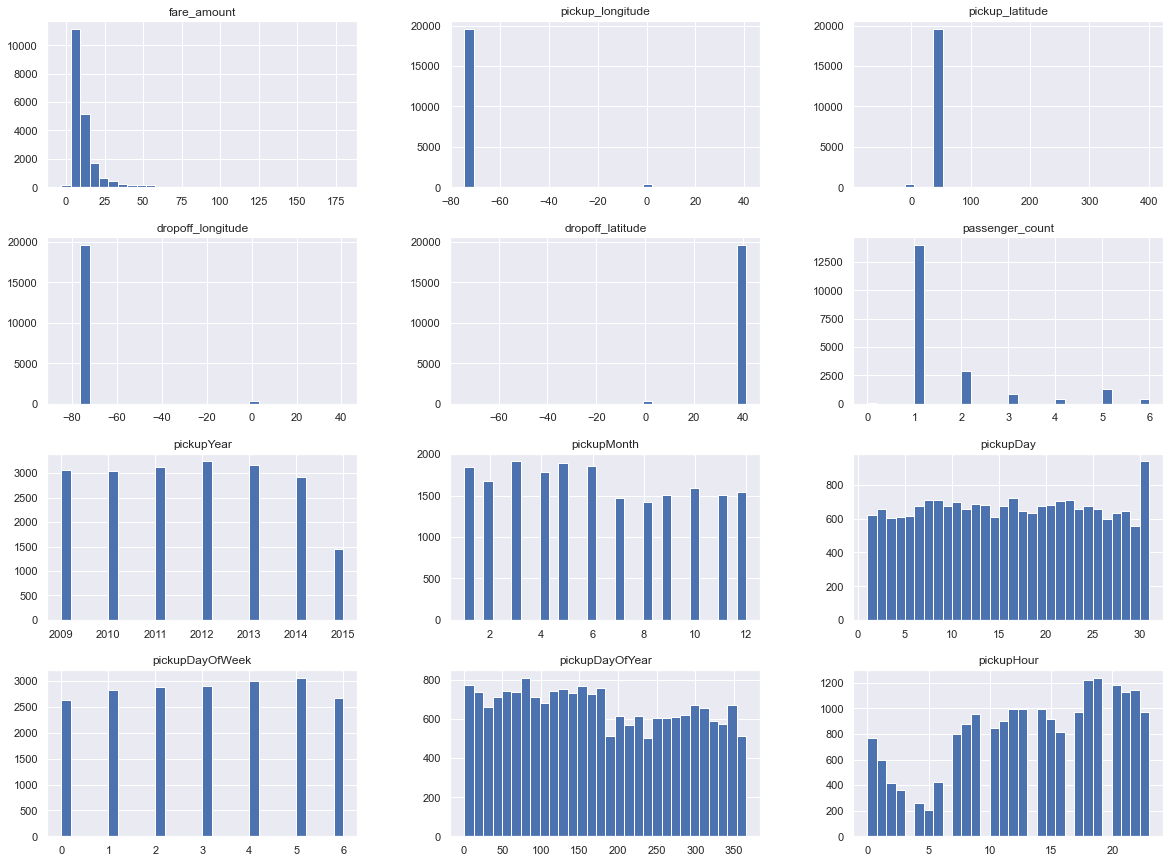

In [22]:
taxi_train_set.hist(bins=30, figsize=(20,15))
plt.show()

We notice that some attributes have a tail-heavy distribution. It seems maybe that long/lat have outliers.
----left-skewed distribution. We can apply log after scaling it, to have better results for the prediction.

In [23]:
pickup_analysis = taxi_train_set[['fare_amount','dropoff_longitude']]
pickup_analysis.head()

,fare_amount,dropoff_longitude
12739,8.6,-73.993356
17546,11.0,-74.004713
8684,10.2,-73.991027
11623,5.3,-73.948735
10004,8.5,-73.977438


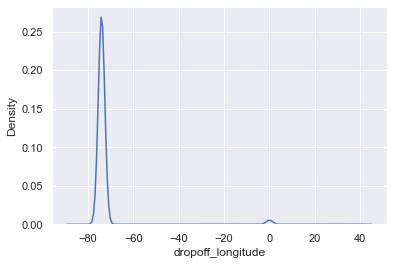

In [24]:
ax = sns.kdeplot(pickup_analysis['dropoff_longitude'])
plt.show()

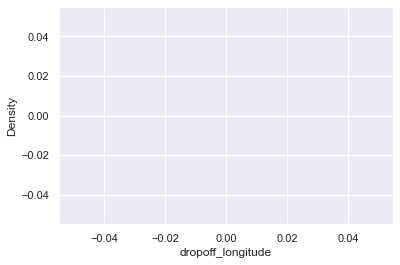

In [25]:
ax = sns.kdeplot(np.log( pickup_analysis['dropoff_longitude'] / np.max(pickup_analysis['dropoff_longitude']) ))
plt.show()

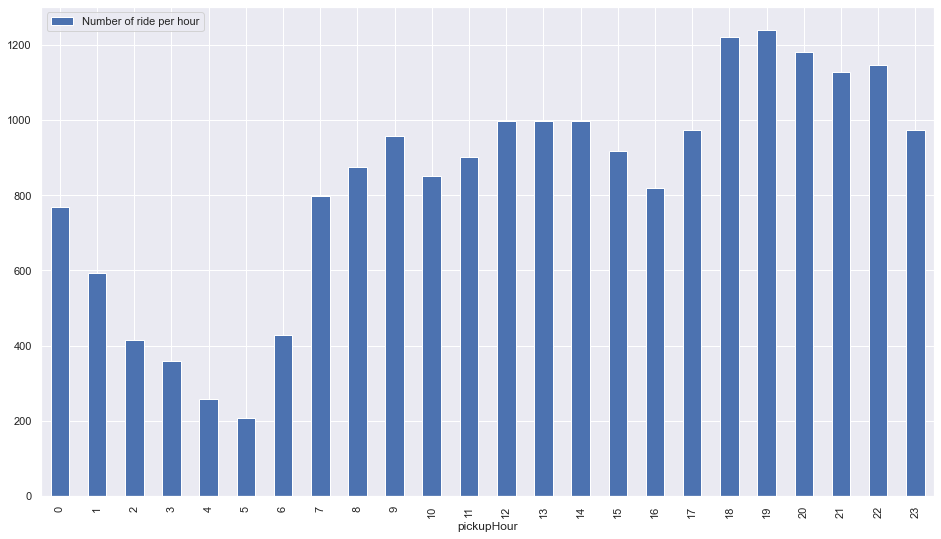

In [26]:
taxi_hours = taxi_train_set[["pickupHour"]]
taxi_hours['count'] = 1
taxi_hours = taxi_hours.groupby('pickupHour').agg('sum')
#taxi_hours = taxi_hours.drop(columns=['pickup'])

ax = taxi_hours.plot(kind='bar', figsize=(16,9))
ax.legend(["Number of ride per hour"])


In [27]:
taxi_train_set.passenger_count.value_counts()

1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64

#### Visualizing Geographical Data

Since there is geographical information (`latitude`, `longitude`), it is a good idea to plot the data of all taxi rides.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


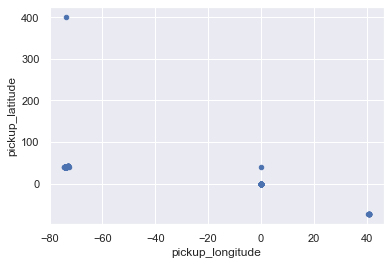

In [28]:
taxi_train_set.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


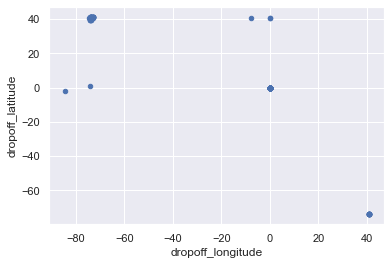

In [29]:
taxi_train_set.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude");

The median is -73.981711 and mean is -72.47858398189526


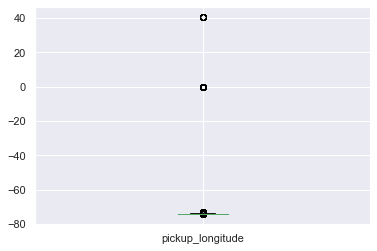

In [30]:
# Plotting the box
taxi_train_set.pickup_longitude.plot.box() 
print("The median is", taxi_train_set.pickup_longitude.median(), "and mean is", taxi_train_set.pickup_longitude.mean())

The median is 40.7526805 and mean is 39.921043062272204


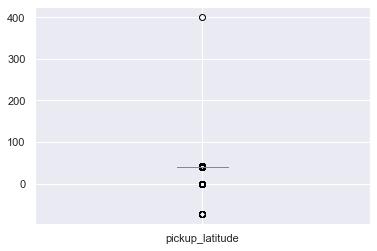

In [31]:
# Plotting the box
taxi_train_set.pickup_latitude.plot.box() 
print("The median is", taxi_train_set.pickup_latitude.median(), "and mean is", taxi_train_set.pickup_latitude.mean())

#### Looking for Correlations

Now let's look at how much each attribute correlates with the fare amount value.

In [32]:
corr_matrix = taxi_train_set.corr()
corr_matrix

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickupYear,pickupMonth,pickupDay,pickupDayOfWeek,pickupDayOfYear,pickupHour
fare_amount,1.000000,0.013226,-0.015276,0.013114,-0.014112,0.010379,0.114919,0.033429,-0.006773,0.001337,0.032767,-0.028001
pickup_longitude,0.013226,1.000000,-0.907930,0.961721,-0.947875,-0.008849,-0.005754,-0.001873,-0.002855,0.001974,-0.002109,-0.005740
pickup_latitude,-0.015276,-0.907930,1.000000,-0.877113,0.894926,0.006015,0.001265,0.003306,0.003817,-0.000149,0.003630,0.004688
dropoff_longitude,0.013114,0.961721,-0.877113,1.000000,-0.977122,-0.007974,-0.007310,-0.001518,-0.004755,0.002041,-0.001923,-0.005655
dropoff_latitude,-0.014112,-0.947875,0.894926,-0.977122,1.000000,0.006698,0.004479,0.003093,0.000760,-0.002995,0.003196,0.006662
passenger_count,0.010379,-0.008849,0.006015,-0.007974,0.006698,1.000000,0.007972,0.009512,-0.000860,0.040471,0.009461,0.018208
pickupYear,0.114919,-0.005754,0.001265,-0.007310,0.004479,0.007972,1.000000,-0.123876,-0.022149,0.007048,-0.125263,-0.001446
pickupMonth,0.033429,-0.001873,0.003306,-0.001518,0.003093,0.009512,-0.123876,1.000000,-0.012861,-0.009721,0.996578,-0.005492
pickupDay,-0.006773,-0.002855,0.003817,-0.004755,0.000760,-0.000860,-0.022149,-0.012861,1.000000,0.012507,0.069531,-0.003701
pickupDayOfWeek,0.001337,0.001974,-0.000149,0.002041,-0.002995,0.040471,0.007048,-0.009721,0.012507,1.000000,-0.008538,-0.091521


In [33]:
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
pickupYear           0.114919
pickupMonth          0.033429
pickupDayOfYear      0.032767
pickup_longitude     0.013226
dropoff_longitude    0.013114
passenger_count      0.010379
pickupDayOfWeek      0.001337
pickupDay           -0.006773
dropoff_latitude    -0.014112
pickup_latitude     -0.015276
pickupHour          -0.028001
Name: fare_amount, dtype: float64

Coefficients close to 0 mean that there is no linear correlation. Only `pickupYear` seems to be correlated with our target `fare_amount`.

The median is 8.5 and mean is 11.3033215


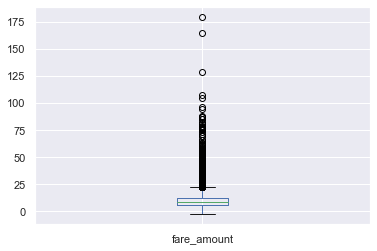

In [34]:
taxi_train_set.fare_amount.plot.box() 
print("The median is", taxi_train_set.fare_amount.median(), "and mean is", taxi_train_set.fare_amount.mean())

#### Conclusion EDA

We have noticed few things about the data so we are going to clean up before feeding the data to a Machine Learning algorithm.

## 3. Prepare the Data.

#### Fix or remove outliers

Here we could skip this step because we have used the StandardScaler and this standardization is not affected by outliers.
If we think that it may affect our estimation, we may want to fix outliers.

* `fare_amount`: drop value > 100
* `longitude`: drop outliers et na
* `latitude`: drop outliers et na
* `passenger_count`: drop value > 6

In [35]:
# Remove outliers and NANs

# Select fare_amount between 0 and 100
taxi_train_set = taxi_train_set[taxi_train_set.fare_amount.between(0,100)]

# Select pickup_longitude and dropoff_longitude between -75 and -71
taxi_train_set = taxi_train_set[(taxi_train_set.pickup_longitude.between(-75,-71)) & (taxi_train_set.dropoff_longitude.between(-75,-71))]

# Select pickup_latitude and dropoff_latitude between 38 and 42
taxi_train_set = taxi_train_set[(taxi_train_set.pickup_latitude.between(38,42)) & (taxi_train_set.dropoff_latitude.between(38,42))]

# Select passenger_count equal or less than 6
taxi_train_set = taxi_train_set[taxi_train_set.passenger_count <= 6]

# Drop na values
taxi_train_set = taxi_train_set[(~taxi_train_set.dropoff_longitude.isna()) | (~taxi_train_set.dropoff_latitude.isna())]

In [36]:
# Let's separate the predictors and the labels
taxi_train = taxi_train_set.drop("fare_amount", axis=1)
taxi_labels = taxi_train_set["fare_amount"].copy()

In [37]:
taxi_train.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickupYear,pickupMonth,pickupDay,pickupDayOfWeek,pickupDayOfYear,pickupHour
12739,2009-01-01 01:31:49.0000003,-73.994192,40.720077,-73.993356,40.742642,1,2009,1,1,3,1,1
17546,2009-01-01 02:05:37.0000004,-73.978433,40.744781,-74.004713,40.734328,1,2009,1,1,3,1,2
8684,2009-01-01 02:51:52.0000002,-73.956172,40.771965,-73.991027,40.751035,2,2009,1,1,3,1,2
11623,2009-01-01 15:19:00.000000146,-73.949937,40.784427,-73.948735,40.773738,5,2009,1,1,3,1,15
10004,2009-01-01 16:52:00.00000053,-73.967647,40.763077,-73.977438,40.787097,2,2009,1,1,3,1,16


In [38]:
taxi_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickupYear,pickupMonth,pickupDay,pickupDayOfWeek,pickupDayOfYear,pickupHour
count,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000,19578.000000
mean,-73.974763,40.750968,-73.973954,40.751423,1.659924,2011.751405,6.246757,15.681173,3.035908,174.591276,13.479416
std,0.041772,0.036667,0.039375,0.038246,1.284915,1.865382,3.445508,8.675372,1.965059,105.090969,6.517916
min,-74.438233,39.603178,-74.227047,39.604972,0.000000,2009.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,-73.992390,40.736431,-73.991407,40.736186,1.000000,2010.000000,3.000000,8.000000,1.000000,84.000000,9.000000
50%,-73.982077,40.753417,-73.980612,40.754273,1.000000,2012.000000,6.000000,16.000000,3.000000,166.000000,14.000000
75%,-73.968112,40.767846,-73.965495,40.768470,2.000000,2013.000000,9.000000,23.000000,5.000000,267.000000,19.000000
max,-72.856968,41.366138,-72.854940,41.366138,6.000000,2015.000000,12.000000,31.000000,6.000000,366.000000,23.000000


In [39]:
taxi_train.dtypes

key                   object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
pickupYear             int64
pickupMonth            int64
pickupDay              int64
pickupDayOfWeek        int64
pickupDayOfYear        int64
pickupHour             int64
dtype: object

In [40]:
taxi_labels.head()

12739     8.6
17546    11.0
8684     10.2
11623     5.3
10004     8.5
Name: fare_amount, dtype: float64

In [41]:
taxi_train["key"].head()

12739      2009-01-01 01:31:49.0000003
17546      2009-01-01 02:05:37.0000004
8684       2009-01-01 02:51:52.0000002
11623    2009-01-01 15:19:00.000000146
10004     2009-01-01 16:52:00.00000053
Name: key, dtype: object

### Data Cleaning, Feature Engineering and Feature Scaling

#### Handling Attributes with Missing Values
As we are not sure that our whole dataset doesn't contain missing values, we will apply the imputer (a Scikit-Learn handy class) to all the numerical attributes. For doing this, we will use the transformer named `SimpleImputer`.


#### Handling Text and Categorical Attributes
In this project, we don't have categorical attributes.
Still, we have to handle the text attribute that is `key`.

We could handle this text attribute by using a regex to split datetime and the id separated by a ".", but we consider that we will not use this id and we already have the datetime information in other attributes, so we'll drop the `key` attribute.


#### Standardize numerical features
ML algorithms don't perform well when the input numerical attributes have very different scales.
This is the case for the taxi data: the `pickup_longitude` ranges from about -74 to 40.767, while the `passenger_count` ranges from 0 to 6. We can apply the StandardScaler transformer.

#### ➡️ Transformation Pipeline

We create a Pipeline so we will be able to apply the transformations to our whole dataset (including the test set) and to new fresh dataset.


In [42]:
# Check which columns are numerical and which one are non numerical
def get_num_col(df):
    """
    Given a dataset, it returns a list of the columns that are numerical.
    """
    num_col = []
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            num_col.append(label)
    return num_col

num_attribs = get_num_col(taxi_train)
num_attribs

['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'pickupYear',
 'pickupMonth',
 'pickupDay',
 'pickupDayOfWeek',
 'pickupDayOfYear',
 'pickupHour']

In [43]:
# Create a pipeline for our numeric attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

# Define our full pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("key_att", "drop", ["key"])
])

taxi_train_prepared = full_pipeline.fit_transform(taxi_train)

In [44]:
taxi_train_prepared.shape

(19578, 11)

### Conclusion of our Preprocessing of Data

We've done some EDA and preprocessing on our data. Now let's start to do some model-driven EDA.

## 4. Select and Train a Model.

### Training and Evaluating on the Training Set

In [45]:
# This is a regression task, so we can first use a LinearRegression model
lin_reg = LinearRegression()
lin_reg.fit(taxi_train_prepared, taxi_labels)

LinearRegression()

Now that we have a working Linear Regression model, let's try it out on a few instances from the training set.

In [46]:
# Let's try our model on some data
some_data = taxi_train.iloc[:5]
some_labels = taxi_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 8.56876963  8.3434661   8.95161446 10.0445168   7.57986829]
Labels: [8.6, 11.0, 10.2, 5.3, 8.5]


In [47]:
# Evaluate our model's predictions
taxi_preds = lin_reg.predict(taxi_train_prepared)
lin_mse = mean_squared_error(taxi_labels, taxi_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8.166863899314343

In [48]:
# Score of our model
lin_reg.score(taxi_train_prepared, taxi_labels)

0.2285849156876707

This is not a very good score, let's try with a Random Forest Regression model.

In [49]:
rd_reg = RandomForestRegressor(n_jobs=1,
                             random_state=42)
rd_reg.fit(taxi_train_prepared, taxi_labels)

print("Predictions:", rd_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 8.574   9.732  10.9977  5.32    8.405 ]
Labels: [8.6, 11.0, 10.2, 5.3, 8.5]


In [50]:
# Evaluate our RandomForestReg's predictions
taxi_preds = rd_reg.predict(taxi_train_prepared)
rd_mse = mean_squared_error(taxi_labels, taxi_preds)
rd_rmse = np.sqrt(rd_mse)
rd_rmse

1.5249104096151485

In [51]:
# Score of our model
rd_reg.score(taxi_train_prepared, taxi_labels)

0.973105334401045

This result is way more better than the first one, but how can we be sure that this model is very good ?

### Better Evaluation Using Cross-Validation

One way to evaluate the Random Forest Regression model would be to use the train_test_split() function to split the training set into a smaller training set and a validation set.

Here we will use the Scikit-Learn's **K-fold cross-validation** feature.

In [52]:
# Here is a function to evaluate our model on a few different levels
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation", scores.std())

In [53]:
# Let's evaluate using the cross-validation
scores = cross_val_score(rd_reg, taxi_train_prepared, taxi_labels,
                        scoring="neg_mean_squared_error", cv=5)
rd_rmse_scores = np.sqrt(-scores)
display_scores(rd_rmse_scores)

Scores: [3.92328344 4.23677373 4.71216644 4.18461923 4.3466174 ]
Mean: 4.280692050022301
Standard deviation 0.25667723647561214


As we can see, our Random Forest Regressor model is performing much better on the training set (RMSE is at 1.525 versus 4.281), meaning that the model is overfitting the training set.

Possible solutions for overfitting are:
* To simplify the model
* Constrain it
* Or get a lot more training data

Let's compute the same scores for the Linear Regression model just to be sure.

In [54]:
lin_scores = cross_val_score(lin_reg, taxi_train_prepared, taxi_labels,
                        scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [7.77851999 8.78744497 8.1539945  8.25753445 9.0613884 ]
Mean: 8.407776460927057
Standard deviation 0.45919460117779454


#### Let's try some other models to get a few (two to five) promising models before diving much deeper into the Fine-Tune Step.

In [55]:
# Here we could try SVM, neural networks...

#### Save our models

In [56]:
# Let's save our models we experiment with so that we can come back easily to any model we want.
import joblib

joblib.dump(lin_reg, "models/taxi_lin_reg_model.pkl")
joblib.dump(rd_reg, "models/taxi_rd_reg_model.pkl")

# to load it : taxi_lin_reg_model = joblib.load("taxi_rd_reg_model.pkl")

['models/taxi_rd_reg_model.pkl']

## 5. Parameters Tuning.

### Fine-tune the hyperparameters

#### Grid Search & Randomized Search

With Scikit-Learn's GridSearchCV , all we need to do is tell it which hyperparameters we want to experiment with and what values to try out and it will use **cross-validation** to evaluate all the possible combinations of hyperparameter values.

In [57]:
# Perform GridSearch
param_grid = [
    {'n_estimators': [10, 30, 40], 'max_features': [6, 8, 10, 12]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(taxi_train_prepared, taxi_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.4min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [6, 8, 10, 12],
                          'n_estimators': [10, 30, 40]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [58]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 40}

Since 8 and 30 are the maximum values that were evaluated, we should probably try searching again with higher values; the score may continue to improve.

In [59]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=40, random_state=42)

In [60]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4.480212384324264 {'max_features': 6, 'n_estimators': 10}
4.312684659079851 {'max_features': 6, 'n_estimators': 30}
4.288685526208269 {'max_features': 6, 'n_estimators': 40}
4.420317326744185 {'max_features': 8, 'n_estimators': 10}
4.295743189019244 {'max_features': 8, 'n_estimators': 30}
4.282837925942666 {'max_features': 8, 'n_estimators': 40}
4.435862676779218 {'max_features': 10, 'n_estimators': 10}
4.320655241274716 {'max_features': 10, 'n_estimators': 30}
4.309960967515424 {'max_features': 10, 'n_estimators': 40}
nan {'max_features': 12, 'n_estimators': 10}
nan {'max_features': 12, 'n_estimators': 30}
nan {'max_features': 12, 'n_estimators': 40}
5.814897201721708 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
5.055410200282633 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5.506766678530013 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
4.766349469208694 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
5.111652966667152 {'bootstrap'

We can se that the best solution by setting the max_features hyperparameters to 6 and the n_estimators hyperparameter to 30. The RMSE score for this combination is **4.885**, which is not better thant the score we got earlier (4.837).

In [61]:
# Perform Randomized Search
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=11),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(taxi_train_prepared, taxi_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff410bc4a00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff410ba3e80>},
                   random_state=42, scoring='neg_mean_squared_error')

In [62]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=44, random_state=42)

In [63]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4.282303279010175 {'max_features': 7, 'n_estimators': 29}
4.311848984419072 {'max_features': 8, 'n_estimators': 21}
4.312443494710822 {'max_features': 7, 'n_estimators': 19}
4.402262896950013 {'max_features': 7, 'n_estimators': 11}
4.293676692138995 {'max_features': 8, 'n_estimators': 36}
4.305896176382234 {'max_features': 8, 'n_estimators': 24}
4.601016564579419 {'max_features': 3, 'n_estimators': 22}
5.421627009886399 {'max_features': 5, 'n_estimators': 2}
4.278094671682071 {'max_features': 8, 'n_estimators': 44}
5.276041285844006 {'max_features': 6, 'n_estimators': 2}


### Ensemble Methods

Another way to fine-tune our system is to try to combine the models that perform best. (Chapter 7)

### Analyze the Best Models and Their Errors

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions.

In [64]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.3026137 , 0.12891754, 0.34098702, 0.14820835, 0.0046625 ,
       0.01954075, 0.00573376, 0.01346279, 0.00812533, 0.01473462,
       0.01301364])

In [65]:
# Let's display these importance scores next to their corresponding attributes names
sorted(zip(feature_importances, num_attribs), reverse=True)

[(0.34098702473282216, 'dropoff_longitude'),
 (0.3026137005850168, 'pickup_longitude'),
 (0.14820834849116693, 'dropoff_latitude'),
 (0.12891754178277828, 'pickup_latitude'),
 (0.01954075231532487, 'pickupYear'),
 (0.014734623625038442, 'pickupDayOfYear'),
 (0.013462786102370962, 'pickupDay'),
 (0.0130136426346204, 'pickupHour'),
 (0.00812532773099214, 'pickupDayOfWeek'),
 (0.005733756899002964, 'pickupMonth'),
 (0.004662495100866278, 'passenger_count')]

With this information, we could try dropping some of the less useful features (e.g., apparently passenger_count is not really useful).

We should also look at the specific errors that our system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).